# Learning avalanche problems by meteorological factors

In [1]:
import pandas as pd
import numpy as np
import json
import graphviz
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from pprint import pprint

pd.set_option("display.max_rows",6)

%matplotlib inline

## Split into test and traininng data to run a prediction
We use the avalanche forecasts from _Nordvestlandet_ including the forecasting regions _Trollheimen_, _Romsdalen_ and _Sunnmøre_. We keep only the parameters provided by the mountain weather forecast. Besides the weather data for the current day we add the precipitation from the previous day as an additional parameter.

We use 75% of the data for training the model and the remaining 25% to test the model afterwards.

In [2]:
df_numdata = pd.read_csv('varsel_nordvestlandet_17_18.csv', index_col=0)

### Remove the "2|" in column Rainfall_Average
df_numdata = df_numdata[df_numdata['Rainfall_Average'] != '2|']        

### create new data columns with previous days weather data
df_numdata['Rainfall_Most_exposed_area_-1day'] = 0 # precip on the day before - be aware that missing index/day will set previous day to zero
for index, row in df_numdata.iterrows():
    try:
        df_numdata.loc[index, 'Rainfall_Most_exposed_area_-1day'] = df_numdata.loc[index-1, 'Rainfall_Most_exposed_area']
    except KeyError:
        print(index-1)

### Randomly shuffle the index of nba.
random_indices = np.random.permutation(df_numdata.index)
### Set a cutoff for how many items we want in the test set (in this case 1/3 of the items)
test_cutoff = np.int(np.floor(len(df_numdata)/4))
print(test_cutoff)
### Generate the test set by taking the first 1/3 of the randomly shuffled indices.
df_test = df_numdata.loc[random_indices[1:test_cutoff]]
### Generate the train set with the rest of the data.
df_train = df_numdata.loc[random_indices[test_cutoff:]]

### Keep only the columns containing weather data...
df_train_target = df_train.filter(['AvalancheProblems_0_Class_AvalancheProblemTypeId'], axis=1) 
df_train_input = df_train.filter(['Rainfall_Most_exposed_area',
                                    'Rainfall_Average',
                                    'Wind_Speed_Num',
                                    'Wind_Direction_Num',
                                    'Temperature_Min',
                                    'Temperature_Max',
                                    'Temperature_masl',
                                    'Freezing_Level_masl',
                                    'Rainfall_Most_exposed_area_-1day'], axis=1)
### ...and split between input and target
df_test_target = df_test.filter(['AvalancheProblems_0_Class_AvalancheProblemTypeId'], axis=1) 
df_test_input = df_test.filter(['Rainfall_Most_exposed_area',
                                    'Rainfall_Average',
                                    'Wind_Speed_Num',
                                    'Wind_Direction_Num',
                                    'Temperature_Min',
                                    'Temperature_Max',
                                    'Temperature_masl',
                                    'Freezing_Level_masl',
                                    'Rainfall_Most_exposed_area_-1day'], axis=1)

-1
378
136


In [3]:
### get the correct target labels
with open(r'../config/snoskred_keys.json') as jdata:
    snoskred_keys = json.load(jdata)
    
enc = LabelEncoder()
label_encoder = enc.fit(df_train_target['AvalancheProblems_0_Class_AvalancheProblemTypeId'])
print ("Categorical classes:", label_encoder.classes_)
class_names2 = []
for l in label_encoder.classes_:
    class_names2.append(snoskred_keys['Class_AvalancheProblemTypeName'][str(l)])
print(class_names2)

### 
train_input = np.array(df_train_input.values, dtype=float)
train_target = np.array(df_train_target.values, dtype=float)

clf2 = tree.DecisionTreeClassifier(min_samples_leaf=8)
clf2 = clf2.fit(train_input, train_target)

### could also use
#clf2 = clf2.fit(df_train_input.values, df_train_target.values)

dot_data2 = tree.export_graphviz(clf2, out_file=None,
                                feature_names = df_train_input.columns.values,
                                class_names = class_names2,
                                #proportion = True, # show precentages instead of members
                                label = "root",
                                filled=True, rounded=True, special_characters=True                                
                                )
graph2 = graphviz.Source(dot_data2) 
graph2.render("avalanche_problem_meteo_train") 

Categorical classes: [2 4 5 6 7]
['Loose wet', 'Wet slab', 'Storm slab', 'Wind slab', 'Persistent slab']


'avalanche_problem_meteo_train.pdf'

We can now compare the prediction by the model to the given target values in the test dataset. 

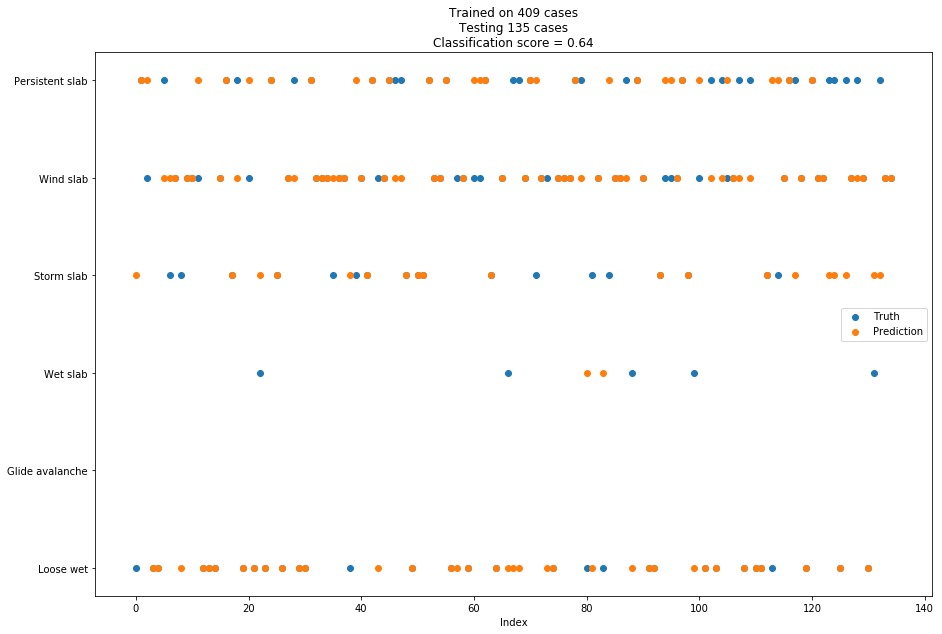

In [4]:
test_input = np.array(df_test_input.values, dtype=float)
test_target = np.array(df_test_target.values, dtype=float)
y = clf2.predict(test_input)
s = clf2.score(test_input, test_target)

i = np.arange(len(y))
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
ax.scatter(i, np.squeeze(test_target), label='Truth')
ax.scatter(i, y, label='Prediction')
plt.xlabel('Index')
#ax = fig.gca()
#index_labels = ax.get_yticklabels()
#named_labels = [snoskred_keys['Class_AvalancheProblemTypeName'][l] for l in index_labels]
#print(list(index_labels))#, named_labels)
named_labels = ["Loose dry", "Loose wet", "Glide avalanche", "Wet slab", "Storm slab", "Wind slab", "Persistent slab",]
ax.set_yticklabels(named_labels)
plt.title('Trained on {2} cases\nTesting {0} cases\nClassification score = {1:0.2f}'.format(len(test_target), s, len(train_target)))
plt.legend()
plt.savefig('nordvestlandet_prediction.pdf')

### Investigating the metrics of the model

In [5]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(test_input, test_target,clf2)#, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.637 

Classification report
             precision    recall  f1-score   support

        2.0       0.72      0.84      0.78        31
        4.0       0.00      0.00      0.00         5
        5.0       0.53      0.56      0.54        18
        6.0       0.71      0.74      0.73        47
        7.0       0.52      0.44      0.48        34

avg / total       0.61      0.64      0.62       135
 

Confusion matrix
[[26  2  2  0  1]
 [ 3  0  2  0  0]
 [ 2  0 10  2  4]
 [ 3  0  0 35  9]
 [ 2  0  5 12 15]] 

